# The HFM library - A fast marching solver with adaptive stencils

## Part : Application examples
## Chapter : A mathematical model for Poggendorff's visual illusions

This python notebook is *freely inspired* from the publication:  
<a id='FMCS_2017'>[1]</a>	B. Franceschiello, A. Mashtakov, G. Citti, and A. Sarti, “Modelling of the Poggendorff Illusion via Sub-Riemannian Geodesics in the Roto-Translation Group,” presented at the International Conference on Image Analysis and Processing, 2017, pp. 37–47.

The main assumption in our experiments is that: if a curve in an image is occluded, then the visual cortex attemps to continue it with a geodesic w.r.t. the Reeds-Shepp model. This assumption is backed by the mathematical works of Petitot and Citti-Sarti, and the neuro-biological observations of Bosking, Angelis, et al, on the first layer V1 of the visual cortex.

The model considered in this notebook is *simplified* in comparison with the one considered in the above paper. Indeed, the original model involves a data adaptive cost function, related to the activation of the cells of V1 implied by the input image, whereas we consider a constant cost function $c=1$ here.

This notebook is intended as a companion notebook for the manuscript [(link)](https://hal.archives-ouvertes.fr/hal-01778322):  
<a name="cite_MP18"> [MP18] </a> Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2018, submitted,
and as documentation for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. It is part of a series, see the [summary](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/Summary.ipynb).

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Sub-Riemannian extrapolation](#1.-Sub-Riemannian-extrapolation)
  * [2. First Poggendorff illusion](#2.-First-Poggendorff-illusion)
  * [3. Poggendorff's round illusion](#3.-Poggendorff's-round-illusion)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

In [1]:
eikonal_mode = 'cpu'

## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Illusion','FMM'))

In [3]:
from agd import Eikonal
from agd.Plotting import savefig; #savefig.dirName = 'Figures/Illusion'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [5]:
def SetDevice():
    global xp,plt
    if eikonal_mode == 'cpu': xp = np
    else:
        import cupy
        from agd import AutomaticDifferentiation as ad
        xp = ad.functional.decorate_module_functions(cupy,ad.cupy_generic.set_output_dtype32) 
        plt = ad.functional.decorate_module_functions(plt,ad.cupy_generic.cupy_get_args(iterables=(tuple,)))
        Eikonal.dictIn.default_mode = eikonal_mode
        ad.array.caster = lambda x:cupy.asarray(x,dtype=np.float32)
SetDevice()

## 1. Sub-Riemannian extrapolation

The two visual illusions considered, due to Poggendorf, challenge our brain's ability to continue a straight or curved line in a region occluded by a vertical band. For both illusions, it is found that we tend to under-estimate the height $y_1$ at the arrival point. 

Following the cited [paper](#FMCS_2017), we model our brain's extrapolation procedure for lines occluded by a vertical band by the following optimization problem. The unknown $\delta y$ determines the height $y_1+\delta y$ on the right side of the vertical band. In the considered examples, the seemingly "logical" continuation (as a straight line, or a circle) would yield $\delta y= 0$, but our brain and the sub-Riemannian model both select a negative value $\delta y <0$.  The optimization problem reads:
\begin{equation*}
    \min_{\delta y \in [-\delta_1,\delta_2]} d_\xi( (x_0,y_0,\theta_0),\ (x_1,y_1+\delta y,\theta_1) )
\end{equation*}
We denoted by $d_\xi$ the sub-Riemannian distance associated with the Reeds-Shepp model on $\mathbb R^2 \times \mathbb P^1$, where $\mathbb P^1 = [0,\pi]$ with periodic boundary conditions. The parameter $\xi$ balances the cost of phisical motion and of angular motion. The inverse $\xi^{-1}$ is homogeneous to a radius of curvature. A large value of $\xi$ yields a large penalization of the curvature of the physical projection of the path to be extracted. 

One weakness of the considered model is that it does not predict the value of parameter $\xi$, which is thus adjusted by hand in the following examples. In addition, this parameter is expected to depend on the scale at which the picture is displayed.

The metric of the $\varepsilon$-relaxation of the Reeds-Shepp model, where $\varepsilon>0$ is a relaxation parameter, reads as follows: for any point $(x,\theta) \in \mathbb R^2 \times \mathbb P^1$ of the configuration space, and any tangent vector $(\dot x, \dot \theta) \in \mathbb R^2 \times \mathbb R$, one has
\begin{equation*}
F_{(x,\theta)}(\dot x,\dot \theta)^2 = <n(\theta),\dot x>^2 + \varepsilon^{-2} <n(\theta)^\perp,\dot x>^2 + \xi^2 |\dot \theta|^2.
\end{equation*}
We denoted $n(\theta) := (\cos \theta,\sin \theta)$. The relaxation parameter $\varepsilon$ formally equals $0$ for the genuine sub-Riemannian mathematical model. However, we need to set $\varepsilon = 0.1$ numerically. In our brain's biological implementation, we expect that $\varepsilon$ is likewise a small positive value.

The function implemented in the next cell numerically solves the optimization problem that we introduced, using the HFM library.

In [6]:
def ReedsSheppContinuation(p0,p1,dy,n=100,n1=5,n2=1,nTheta=120,xi=1):
    hfmIn = Eikonal.dictIn({
        'model':'ReedsShepp2',
        'geodesicSolver':'ODE',
        'order':2,
        'cost':1,
        'xi':xi,
        'projective':1,
    })
    
    x0,y0,_ = p0
    x1,y1,theta1 = p1
    nDown,nUp = (n1,n2) if y1>y0 else (n2,n1)
    hfmIn.SetRect([[min(x0,x1),max(x0,x1)],[min(y0,y1-nDown*dy),max(y0,y1+nUp*dy)]], 
                  dimx=n,sampleBoundary=True)
    hfmIn.nTheta = nTheta

    # First run : compute the best overall tip
    h=hfmIn['gridScale']
    hfmIn['seeds'] = [[x1,y1+n*h,theta1] for n in range(int(-nDown*dy/h),int(nUp*dy/h)+1)]
    hfmIn['tips'] = [p0]
    hfmOut1 = hfmIn.Run()

    # Second run : compute the best suggested tip
    hfmIn['seeds'] = [p0]
    hfmIn['tips'] = [[x1,y1+n*dy,theta1] for n in range(-nDown,nUp+1)]
    hfmIn['exportValues']=1
    hfmOut2 = hfmIn.Run()

    tipsI,_ = hfmIn.IndexFromPoint(hfmIn['tips'])
    tipValues = hfmOut2['values'][tuple(tipsI.T)]
        
    return hfmOut1['geodesics'][0], hfmOut2['geodesics'], tipValues

In [7]:
geoOpt, geoAll, tipValues = ReedsSheppContinuation([0,0,np.pi/4],[1,1,np.pi/4],0.1,xi=0.7)

Field verbosity defaults to 1
Field eps defaults to 0.1
Field seedRadius defaults to 0
Fast marching solver completed in 1.436 s.
Field geodesicStep defaults to 0.25
Field geodesicCausalityTolerance defaults to 4
Field geodesicTargetTolerance defaults to 6
Field verbosity defaults to 1
Field eps defaults to 0.1
Field seedRadius defaults to 0
Fast marching solver completed in 1.519 s.
Field geodesicStep defaults to 0.25
Field geodesicCausalityTolerance defaults to 4
Field geodesicTargetTolerance defaults to 6


The next cell shows the minimal geodesic for the considered optimization problem, which will appear as our brain's approximation of a straight line in the first Poggendorff illusion.

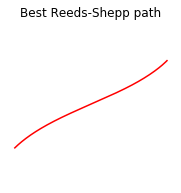

In [8]:
fig = plt.figure(figsize=[3,3]); plt.title('Best Reeds-Shepp path'); plt.axis('equal'); plt.axis('off');
plt.plot(geoOpt[0],geoOpt[1],color='red');
savefig(fig,'ReedsSheppPath.png')

We next display a family of geodesics, from the left to the right of the domain, with the prescribed tangents, colored according to their length. (Shortest is darker)

In [9]:
def toGray(vals):
    grays = np.sqrt(vals-min(vals))
    grays = grays/max(grays)
    return 0.8*grays

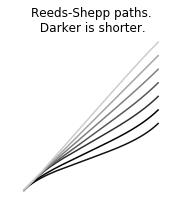

In [10]:
fig = plt.figure(figsize=[3,3]); plt.axis('equal'); plt.axis('off');
plt.title('Reeds-Shepp paths.\n Darker is shorter.',fontdict={'verticalalignment':'top'}); 
for geo,lvl in zip(geoAll,toGray(tipValues)):
    plt.plot(geo[0],geo[1],color=(lvl,lvl,lvl));
savefig(fig,'ReedsSheppPaths.png')

## 2. First Poggendorff illusion

The first Poggendorff illusion challenges our brain's ability to continue a straight line occluded by a vertical band. The function implemented in the next cell displays the illusion, and returns the endpoints of the occluded segment.

In [11]:
def BarIllusion(theta,r,w):
    c,s=np.cos(theta),np.sin(theta)
    fig = plt.figure()
    plt.axis('equal')
    plt.axis('off')
    plt.plot([-c,-r*c],[-s,-r*s],color='black')
    plt.plot([c,r*c],[s,r*s],color='black')
    plt.plot([-r*c,-r*c],[-s,s],color='gray')
    plt.plot([r*c,r*c],[-s,s],color='gray')
    return fig,np.array([[-r*c,-r*s,theta],[r*c,r*s,theta]])

When viewing the Poggendorff illusion, in the next cell, most people tend to think that the dark straight lines are not aligned, but that the right one is a little *too high*. This is actually not the case, as evidenced by the above python code.

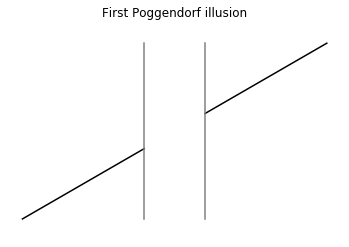

In [12]:
fig,endPts = BarIllusion(np.pi/6,0.2,10);
plt.title('First Poggendorf illusion');
savefig(fig,'FirstPoggendorffIllusion.png')

We next try to explain Poggendorff's illusion using the sub-Riemannian Reeds-Shepp model. The red curve supposedly accounts for our brain's completion of the left black line, in the space in between the two gray lines. 

In [13]:
geoOpt,geoAll,tipValues = ReedsSheppContinuation(endPts[0,:],endPts[1,:],0.02,xi=0.25)

Field verbosity defaults to 1
Field eps defaults to 0.1
Field seedRadius defaults to 0
Fast marching solver completed in 0.762 s.
Field geodesicStep defaults to 0.25
Field geodesicCausalityTolerance defaults to 4
Field geodesicTargetTolerance defaults to 6
Field verbosity defaults to 1
Field eps defaults to 0.1
Field seedRadius defaults to 0
Fast marching solver completed in 0.821 s.
Field geodesicStep defaults to 0.25
Field geodesicCausalityTolerance defaults to 4
Field geodesicTargetTolerance defaults to 6
Geodesic ODE solver seems to have failed for tip {0.173205,0.04,0.523599}.


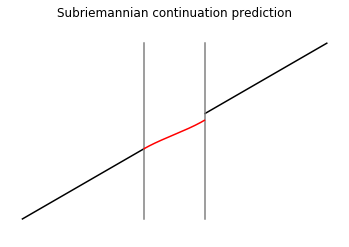

In [14]:
fig,_ = BarIllusion(np.pi/6,0.2,10);
plt.title('Subriemannian continuation prediction');
plt.plot(geoOpt[0],geoOpt[1],color='red');
savefig(fig,'FirstPoggendorffIllusion_Prediction.png')

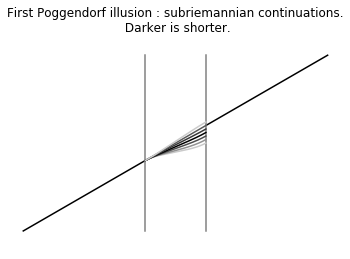

In [15]:
fig,_ = BarIllusion(np.pi/6,0.2,10);
plt.title('First Poggendorf illusion : subriemannian continuations.\n Darker is shorter.',fontdict={'verticalalignment':'top'});
for geo,lvl in zip(geoAll,toGray(tipValues)):
    plt.plot(geo[0],geo[1],color=(lvl,lvl,lvl));
savefig(fig,'FirstPoggendorffIllusion_Choices.png')

## 3. Poggendorff's round illusion

We next turn to a second illusion due to Poggendorff, involving the completion of a circular shape.

In [16]:
def RoundIllusion(theta1,theta2,w):
    c1,s1 = np.cos(theta1),np.sin(theta1)
    c2,s2 = np.cos(theta2),np.sin(theta2)
    fig = plt.figure()
    plt.axis('equal')
    plt.axis('off')
    plt.plot([c1,c1],[-1,1],color='grey')
    plt.plot([c2,c2],[-1,1],color='grey')
    I1 = np.linspace(-theta1,theta1,100)
    I2 = np.linspace(theta2,2*np.pi-theta2,100)
    plt.plot([np.cos(t) for t in I1],[np.sin(t) for t in I1],color='black',solid_capstyle='round')
    plt.plot([np.cos(t) for t in I2],[np.sin(t) for t in I2],color='black',solid_capstyle='round')
    return fig, np.array([[c1,s1,theta1+np.pi/2],[c2,s2,theta2+np.pi/2]])

The dark line is circular, yet most people feel that the occluded parts to not connect well.

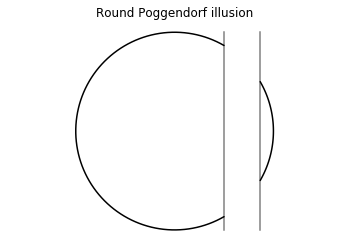

In [17]:
fig,endPts = RoundIllusion(np.pi/6,np.pi/3,6);
plt.title('Round Poggendorf illusion');
savefig(fig,'RoundPoggendorffIllusion.png')

In [18]:
geoOpt,geoAll,tipValues = ReedsSheppContinuation(endPts[0,:],endPts[1,:],0.04,xi=0.5)

Field verbosity defaults to 1
Field eps defaults to 0.1
Field seedRadius defaults to 0
Fast marching solver completed in 1.425 s.
Field geodesicStep defaults to 0.25
Field geodesicCausalityTolerance defaults to 4
Field geodesicTargetTolerance defaults to 6
Field verbosity defaults to 1
Field eps defaults to 0.1
Field seedRadius defaults to 0
Fast marching solver completed in 1.528 s.
Field geodesicStep defaults to 0.25
Field geodesicCausalityTolerance defaults to 4
Field geodesicTargetTolerance defaults to 6


Our brain's completion of the occluded part, according to the considered sub-Riemannian model.

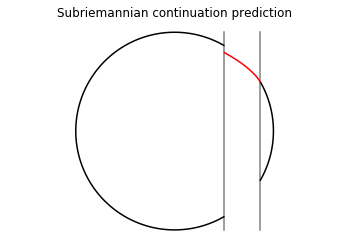

In [19]:
fig,_ = RoundIllusion(np.pi/6,np.pi/3,6);
plt.title('Subriemannian continuation prediction');
plt.plot(geoOpt[0],geoOpt[1],color='red');
savefig(fig,'RoundPoggendorffIllusion_Prediction.png')

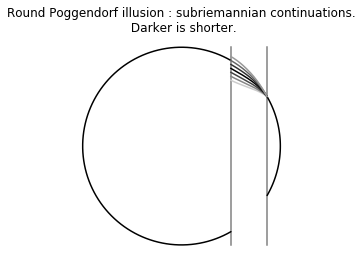

In [20]:
fig,_ = RoundIllusion(np.pi/6,np.pi/3,6);
plt.title('Round Poggendorf illusion : subriemannian continuations.\n Darker is shorter.');
for geo,lvl in zip(geoAll,toGray(tipValues)):
    plt.plot(geo[0],geo[1],color=(lvl,lvl,lvl));
savefig(fig,'RoundPoggendorffIllusion_Choices.png')